# Introduction

Yet another meaningful and interesting Kaggle competition, wherein this time the aim is to predict a patient’s severity of decline in lung function.

In this notebook, we aim to perform an EDA of the given traincsv dataset

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pydicom

In [2]:
root_dir = "/kaggle/input/osic-pulmonary-fibrosis-progression"
train_dir = os.path.join(root_dir,'train')
test_dir = os.path.join(root_dir,'test')
train_csv_path = os.path.join(root_dir,'train.csv')
test_csv_path = os.path.join(root_dir,'test.csv')

In [3]:
df_train = pd.read_csv(train_csv_path)
df_test = pd.read_csv(test_csv_path)

### Lets check the sanity of the datasets: i.e. null values, shape etc

In [4]:
print(df_train.shape)
print(df_test.shape)

(1549, 7)
(5, 7)


In [5]:
for col in df_train.columns:
    print("Number of null values in column {} is {}".format(col,sum(df_train[col].isnull())))

Number of null values in column Patient is 0
Number of null values in column Weeks is 0
Number of null values in column FVC is 0
Number of null values in column Percent is 0
Number of null values in column Age is 0
Number of null values in column Sex is 0
Number of null values in column SmokingStatus is 0


### Lets first try to find number of patients:

In [6]:
df_train.groupby(['Patient']).count()

,Weeks,FVC,Percent,Age,Sex,SmokingStatus
Patient,,,,,,
ID00007637202177411956430,9,9,9,9,9,9
ID00009637202177434476278,9,9,9,9,9,9
ID00010637202177584971671,9,9,9,9,9,9
ID00011637202177653955184,9,9,9,9,9,9
ID00012637202177665765362,9,9,9,9,9,9
...,...,...,...,...,...,...
ID00419637202311204720264,9,9,9,9,9,9
ID00421637202311550012437,10,10,10,10,10,10
ID00422637202311677017371,8,8,8,8,8,8


In [7]:
list_patient_ids = list(df_train['Patient'].unique())
print("Number of patients: {}".format(len(list_patient_ids)))

Number of patients: 176


So we have datapoints pertaining to 176 patients. To be specific, we know the below related to these 176 patients:

A. ID  => unique id for each patient - also the name of the DICOM folder in train

B. Weeks => the relative number of weeks before/after the baseline CT was taken. This is the same baseline CT present in the DICOM folder 

C. FVC => the recorded lung capacity in ml

D. Percent => a computed field which approximates the patient's FVC as a percent of the typical FVC for a person of similar characteristics

E. Age => age of the patient

F. Sex => gender of the patient

G. Smoking Status => whether patient smokes or not

In [8]:
df_train.columns

Index(['Patient', 'Weeks', 'FVC', 'Percent', 'Age', 'Sex', 'SmokingStatus'], dtype='object')

We will check in the dataset whether for a given patient, is there a change in values for:

a. age  - probably during the course, there could have been a change in person's age

b. smokingstatus - checking whether there was any change in smoking status for the patient e.g whether the patient went to 'Never Smokes' to 'Currently Smokes' or 'Ex smoker' to 'Currently Smokes'

c. sex - for data sanity

This check wouldnt make sense if above patient attributes were only taken once. Since we do not know this, its best to check to eliminate any data discrepancies

In [9]:
for pat_id in list_patient_ids:    
    age_unique = len(df_train.loc[df_train['Patient']==pat_id,'Age'].unique())
    smoke_unique = len(df_train.loc[df_train['Patient']==pat_id,'SmokingStatus'].unique())    
    sex_unique = len(df_train.loc[df_train['Patient']==pat_id,'Sex'].unique())
    
    if sex_unique !=1:
        print("Please check sex column for patient id:".format(pat_id))
    if age_unique !=1:
        print("Please check age column for patient id:".format(pat_id))
    if smoke_unique !=1:
        print("Please check smoking_status column for patient id:".format(pat_id))

We dont have any such discrepancies, so 'age', 'smokingstatus' and 'sex' are constant for a given patient id.

So lets create a patient information dictionary, for future use

In [10]:
pat_info_dict = {}
for pat_id in list_patient_ids:    
    pat_info_dict[pat_id] = {}
    pat_info_dict[pat_id]['age'] = list(df_train.loc[df_train['Patient']==pat_id,'Age'].unique())[0]
    pat_info_dict[pat_id]['sex'] = list(df_train.loc[df_train['Patient']==pat_id,'Sex'].unique())[0]
    pat_info_dict[pat_id]['smokingstatus'] = list(df_train.loc[df_train['Patient']==pat_id,'SmokingStatus'].unique())[0]
    smoke_unique = len(df_train.loc[df_train['Patient']==pat_id,'SmokingStatus'].unique())

### Now lets analyze the distribution

In [11]:
df_pat_analysis = df_train.loc[:,['Patient','Age','Sex','SmokingStatus']].drop_duplicates()

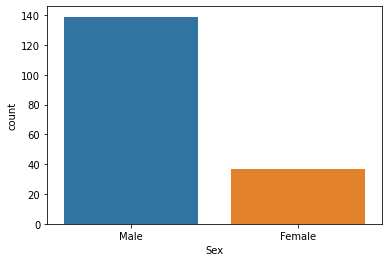

In [12]:
sns.countplot(df_pat_analysis['Sex'])

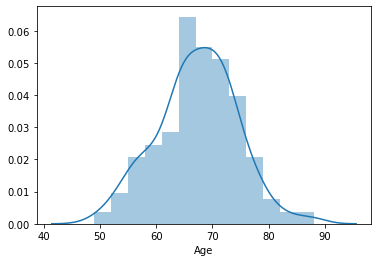

In [13]:
sns.distplot(df_pat_analysis['Age'])

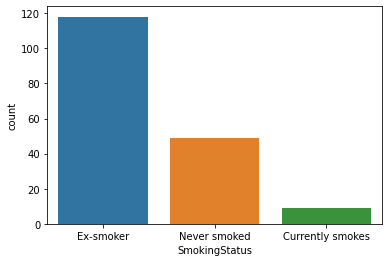

In [14]:
sns.countplot(df_pat_analysis['SmokingStatus'])

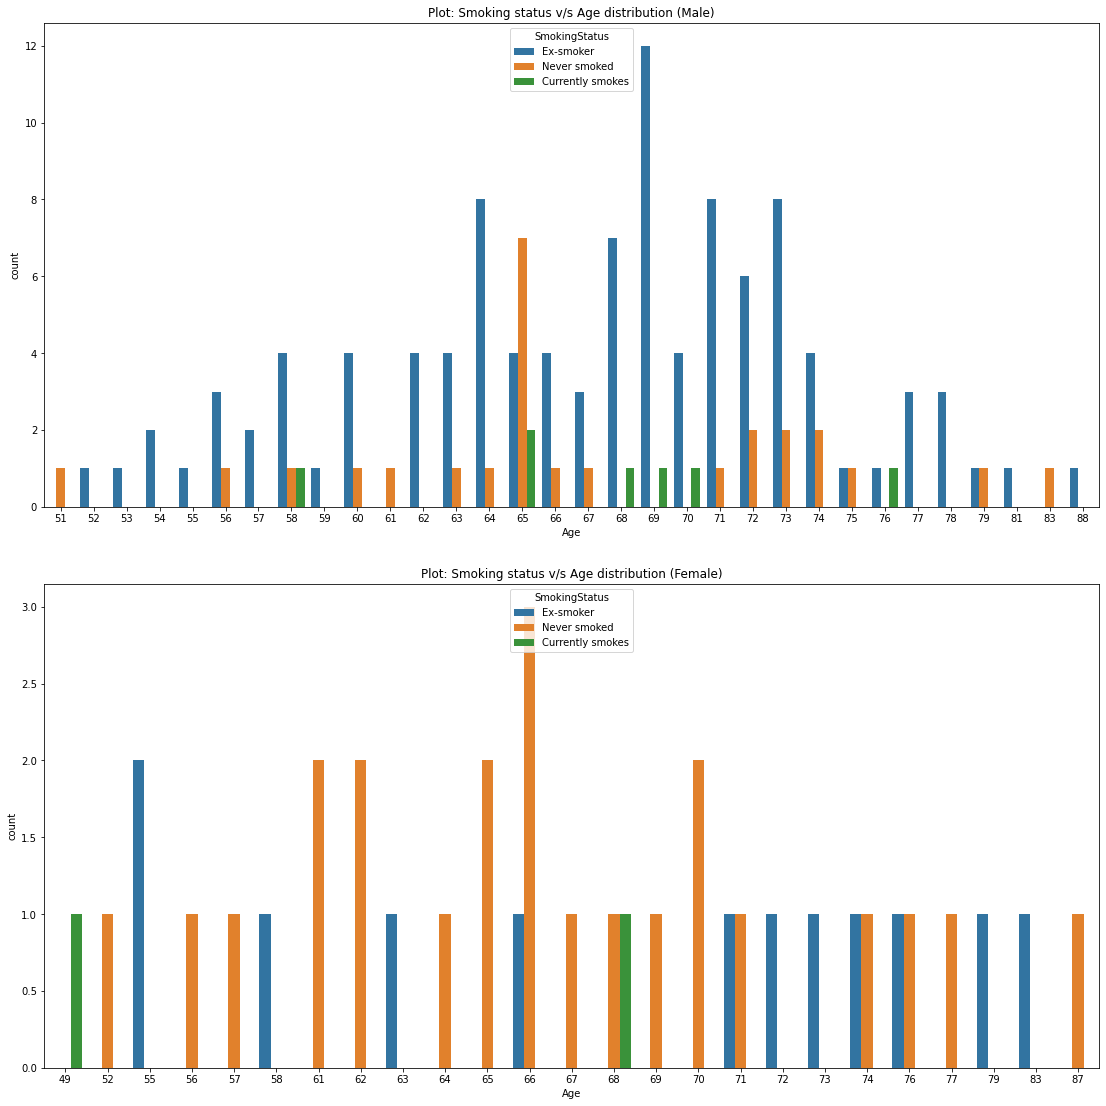

In [15]:
#ax = fig.add_subplot(111)
fig, ax =plt.subplots(nrows=2,ncols=1,figsize=(16,16),squeeze=False)
#ax[0,0].scatter(xdf['landmark_id'],xdf['count'],c=xdf['landmark_id'],s=50)
#ax[0,0].tick_params(axis='x',rotation=45)
#ax[0,0].title.set_text('scatter plot: landmark_id v/s count ')

sns.countplot(x="Age", hue="SmokingStatus", data=df_pat_analysis.loc[df_pat_analysis['Sex']=="Male"],ax=ax[0,0])
ax[0,0].title.set_text('Plot: Smoking status v/s Age distribution (Male)')

sns.countplot(x="Age", hue="SmokingStatus", data=df_pat_analysis.loc[df_pat_analysis['Sex']=="Female"],ax=ax[1,0])
ax[1,0].title.set_text('Plot: Smoking status v/s Age distribution (Female)')

fig.tight_layout(pad=3.0)


plt.show()

Distribution Inferences: 
1. Distibrution of age is following more  or less a gaussian distribution with mean center around the age of 65-70
2. You have a greater count of male patients and "Ex-smoker" patients
3. You can see a dominance of "Ex-smoker" class within male patients, however "Never-Smoked" tends to edge out "Ex-smoker" in the female patients

With a fair understanding of distribution of patient attributes, lets now incorporate the remaining attributes which shed light on the their visits and lung capacity i.e.
"Weeks"
"FVC", and
"Percent"

In [16]:
df_train.columns

Index(['Patient', 'Weeks', 'FVC', 'Percent', 'Age', 'Sex', 'SmokingStatus'], dtype='object')

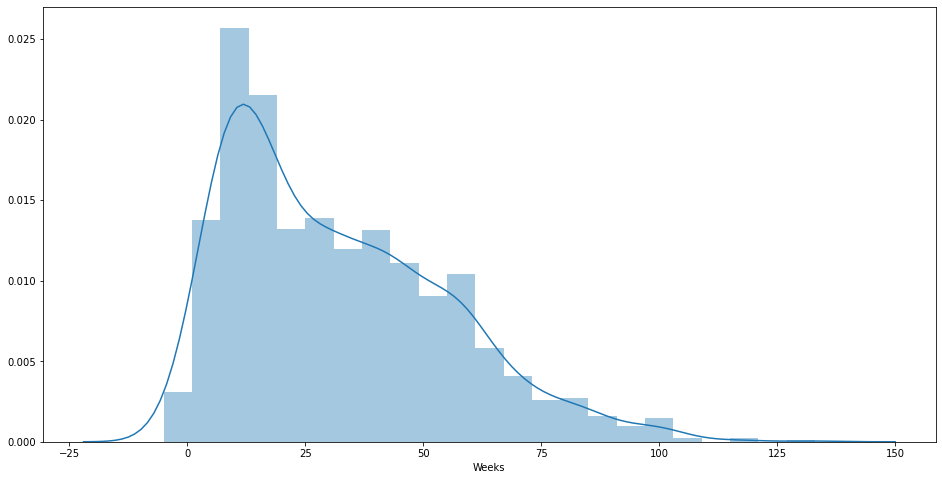

In [17]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,8),squeeze=False)
sns.distplot(df_train['Weeks'],ax =ax[0,0])

# Patient Card

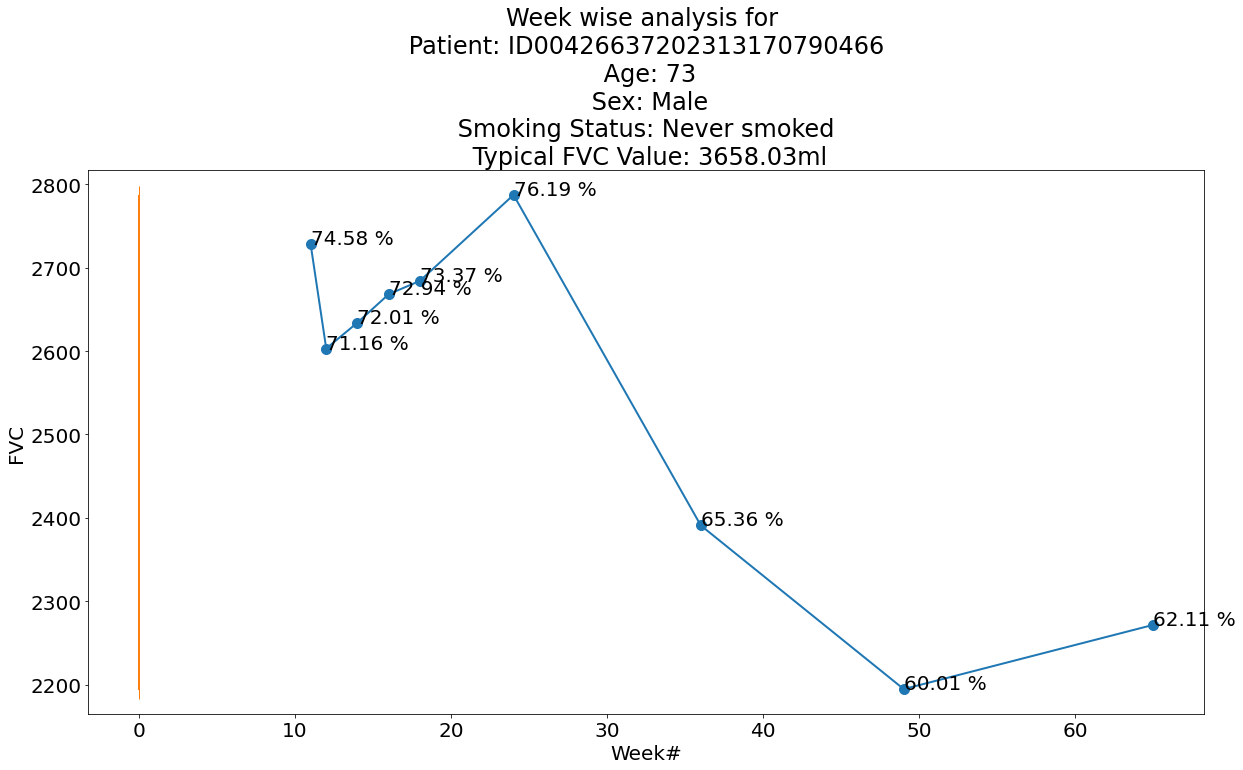

In [18]:
patient_id = random.choice(list_patient_ids)
df_pat = df_train.loc[df_train['Patient']==patient_id]

plt.figure(figsize=(20,10))
# Changing default values for parameters individually
plt.rc('lines', linewidth=2, linestyle='-', marker='.')
plt.rcParams['lines.markersize'] = 20
plt.rcParams['font.size'] = '20.0'
 
#Plot a line graph
plt.plot(df_pat['Weeks'],df_pat['FVC'])

typical_fvc=0
for x,y in zip(df_pat['Weeks'],df_pat['FVC']):
    
    percent_mark = round(list(df_pat.loc[df_pat['Weeks']==x].loc[df_pat['FVC']==y]['Percent'])[0],2)
    disp_str = "{} %".format(percent_mark)
    typical_fvc = round(y*100/percent_mark,2)
    #print("Typical FVC value is {}".format(typical_fvc))
    plt.text(x,y,disp_str)


    
# Lets plot the CT Scan week 
ct_scan_line = range(int(min(df_pat['FVC'])), int(max(df_pat['FVC'])))
max_len = len(ct_scan_line)
plt.plot([0]*max_len,ct_scan_line, marker = '|')


# Add labels and title
plt.title("Week wise analysis for \n Patient: {} \n Age: {}\n Sex: {}\n Smoking Status: {} \n Typical FVC Value: {}ml".format(pat_id,pat_info_dict[pat_id]['age'],pat_info_dict[pat_id]['sex'],pat_info_dict[pat_id]['smokingstatus'],typical_fvc))
plt.xlabel("Week#")
plt.ylabel("FVC")
 
plt.show()